## DEBIASING: 
As Equalized Odds balances both FPR and TPR, we have seen that in our scenario we only care about FPR. In the following the FPR parity should be used as debiasing method. 
Thus, another audit on FPR parity will be made to set the baseline for debiasing: 

In [6]:
# FPR Parity Auditing (by Gender)

from fairlearn.metrics import false_positive_rate, MetricFrame
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from datetime import datetime

# Load Validation Data and Models
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)

selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Reproduce splits
X_trainval, X_test, y_trainval, y_test, X_raw_trainval, X_raw_test = train_test_split(
    X_selected, y, X_raw, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val, X_raw_train, X_raw_val = train_test_split(
    X_trainval, y_trainval, X_raw_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

# Load finetuned models
logreg = joblib.load("../models/tuned/logistic_regression_finetuned.pkl")
adaboost = joblib.load("../models/tuned/adaboost_finetuned.pkl")
neural_net = joblib.load("../models/tuned/neural_network_finetuned.pkl")

# FPR audit results
models = {
    "Logistic Regression": logreg,
    "AdaBoost": adaboost,
    "Neural Network": neural_net
}

# FPR audit results
audit_results = []

for name, model in models.items():
    mf_fpr = MetricFrame(
        metrics=false_positive_rate,
        y_true=y_val,
        y_pred=model.predict(X_val),
        sensitive_features=X_raw_val["sex"]
    )
    for group in mf_fpr.by_group.index:
        audit_results.append({
            "Model": name,
            "Group": group,
            "FPR": mf_fpr.by_group[group],
            "Timestamp": datetime.now().isoformat()
        })

# Save results
audit_df = pd.DataFrame(audit_results)
output_path = "../reports/04_fairness/fpr_parity_audit_sex.csv"
audit_df.to_csv(output_path, index=False)

audit_df.head()

,Model,Group,FPR,Timestamp
0,Logistic Regression,Female,0.191964,2025-04-22T10:54:17.991100
1,Logistic Regression,Male,0.258750,2025-04-22T10:54:17.991100
2,AdaBoost,Female,0.133929,2025-04-22T10:54:18.047678
3,AdaBoost,Male,0.166250,2025-04-22T10:54:18.047678
4,Neural Network,Female,0.191964,2025-04-22T10:54:18.076508


In [7]:
# FPR Parity Auditing (by Race)


# Load Validation Data and Models
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)

selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Reproduce splits
X_trainval, X_test, y_trainval, y_test, X_raw_trainval, X_raw_test = train_test_split(
    X_selected, y, X_raw, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val, X_raw_train, X_raw_val = train_test_split(
    X_trainval, y_trainval, X_raw_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

# Load finetuned models
logreg = joblib.load("../models/tuned/logistic_regression_finetuned.pkl")
adaboost = joblib.load("../models/tuned/adaboost_finetuned.pkl")
neural_net = joblib.load("../models/tuned/neural_network_finetuned.pkl")

# FPR audit results
models = {
    "Logistic Regression": logreg,
    "AdaBoost": adaboost,
    "Neural Network": neural_net
}

# FPR audit results
audit_results = []

for name, model in models.items():
    mf_fpr = MetricFrame(
        metrics=false_positive_rate,
        y_true=y_val,
        y_pred=model.predict(X_val),
        sensitive_features=X_raw_val["race"]
    )
    for group in mf_fpr.by_group.index:
        audit_results.append({
            "Model": name,
            "Group": group,
            "FPR": mf_fpr.by_group[group],
            "Timestamp": datetime.now().isoformat()
        })

# Save results
audit_df = pd.DataFrame(audit_results)
output_path = "../reports/04_fairness/fpr_parity_audit_race.csv"
audit_df.to_csv(output_path, index=False)

audit_df.head()

,Model,Group,FPR,Timestamp
0,Logistic Regression,African-American,0.326271,2025-04-22T10:54:18.564318
1,Logistic Regression,Asian,0.000000,2025-04-22T10:54:18.564318
2,Logistic Regression,Caucasian,0.183288,2025-04-22T10:54:18.564318
3,Logistic Regression,Hispanic,0.180180,2025-04-22T10:54:18.564318
4,Logistic Regression,Native American,0.200000,2025-04-22T10:54:18.564318


In [8]:
audit_path = "../reports/04_fairness/fpr_parity_audit_race.csv"
audit_df = pd.read_csv(audit_path)
print(audit_df.columns)

Index(['Model', 'Group', 'FPR', 'Timestamp'], dtype='object')


Now construct a custom threshold optimizer to minimize FPR across groups. 

In [9]:
# Debias FPR on sensitive group "sex" using previous audit results

import pandas as pd
import numpy as np
import joblib, os
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from fairlearn.metrics import false_positive_rate, MetricFrame
from sklearn.model_selection import train_test_split
from datetime import datetime

# === Custom Wrapper for Debiased Classifier ===
class DebiasedClassifier:
    def __init__(self, model, thresholds, sensitive_feature):
        self.model = model
        self.thresholds = thresholds
        self.sensitive_feature = sensitive_feature

    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1]

    def predict(self, X, X_raw):
        probs = self.predict_proba(X)
        groups = X_raw[self.sensitive_feature].values
        preds = [
            1 if p >= self.thresholds.get(g, 0.5) else 0
            for p, g in zip(probs, groups)
        ]
        return np.array(preds)

# === Load data and pipeline ===
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)

selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# === Recreate splits ===
X_trainval, X_test, y_trainval, y_test, X_raw_trainval, X_raw_test = train_test_split(
    X_selected, y, X_raw, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val, X_raw_train, X_raw_val = train_test_split(
    X_trainval, y_trainval, X_raw_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

# === Load finetuned models ===
logreg = joblib.load("../models/tuned/logistic_regression_finetuned.pkl")
adaboost = joblib.load("../models/tuned/adaboost_finetuned.pkl")
neural_net = joblib.load("../models/tuned/neural_network_finetuned.pkl")

models = {
    "Logistic Regression": logreg,
    "AdaBoost": adaboost,
    "Neural Network": neural_net
}

# === Load prior FPR audit results ===
fpr_audit = pd.read_csv("../reports/04_fairness/fpr_parity_audit_sex.csv")
fpr_audit = fpr_audit[fpr_audit["Group"].isin(["Male", "Female"])]
fpr_audit = fpr_audit.pivot(index="Model", columns="Group", values="FPR")

# === Group-wise FPR Threshold Tuning ===
def optimal_thresholds_by_group(model, X_val, y_val, group_attr, group_labels, metric=false_positive_rate):
    probas = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 41)
    best = {}

    for group in group_labels:
        best_gap = float("inf")
        best_threshold = 0.5
        for t in thresholds:
            preds = (probas >= t).astype(int)
            fpr = MetricFrame(metrics=metric, y_true=y_val, y_pred=preds, sensitive_features=group_attr)
            gap = abs(fpr.by_group.max() - fpr.by_group.min())
            if gap < best_gap:
                best_gap = gap
                best_threshold = t
        best[group] = best_threshold
    return best

# === Apply and Evaluate Group Thresholds ===
results = []
sensitive_attr = "sex"
group_labels = ["Male", "Female"]
X_sensitive = X_raw_val[sensitive_attr]
group_map = dict(zip(X_raw_val.index, X_sensitive))

os.makedirs("../models/debiased", exist_ok=True)

for model_name, model in models.items():
    probas = model.predict_proba(X_val)[:, 1]
    thresholds = optimal_thresholds_by_group(model, X_val, y_val, X_sensitive, group_labels)

    val_indices = X_raw_val.index
    preds = []
    for i, p in enumerate(probas):
        group = group_map[val_indices[i]]
        threshold = thresholds.get(group, 0.5)
        preds.append(1 if p >= threshold else 0)

    preds = np.array(preds)
    fpr = MetricFrame(metrics=false_positive_rate, y_true=y_val, y_pred=preds, sensitive_features=X_sensitive)

    try:
        baseline_male = fpr_audit.loc[model_name, "Male"]
        baseline_female = fpr_audit.loc[model_name, "Female"]
        baseline_gap = abs(baseline_male - baseline_female)
    except KeyError:
        baseline_male = baseline_female = baseline_gap = np.nan

    results.append({
        "Model": model_name,
        "Baseline FPR (Male)": round(baseline_male, 3),
        "Baseline FPR (Female)": round(baseline_female, 3),
        "Baseline FPR Gap": round(baseline_gap, 4),
        "FPR (Male)": round(fpr.by_group["Male"], 3),
        "FPR (Female)": round(fpr.by_group["Female"], 3),
        "FPR Gap (Postprocessed)": round(abs(fpr.by_group["Male"] - fpr.by_group["Female"]), 4),
        "Threshold (Male)": round(thresholds["Male"], 2),
        "Threshold (Female)": round(thresholds["Female"], 2),
        "Timestamp": datetime.now().isoformat()
    })

    # Save model if FPR improved for both groups
    if fpr.by_group["Male"] < baseline_male and fpr.by_group["Female"] < baseline_female:
        wrapped_model = DebiasedClassifier(model, thresholds, sensitive_feature="sex")
        filename = f"../models/debiased/{model_name.lower().replace(' ', '_')}_debiased.pkl"
        joblib.dump(wrapped_model, filename)
        print(f"[SAVED] Debiased model saved: {filename}")
    else:
        print(f"[SKIPPED] Debiasing ineffective for {model_name}, not saved.")

# === Save results ===
df_results = pd.DataFrame(results)
os.makedirs("../reports/04_fairness", exist_ok=True)
df_results.to_csv("../reports/04_fairness/fpr_parity_results_sex.csv", index=False)
df_results





[SKIPPED] Debiasing ineffective for Logistic Regression, not saved.
[SKIPPED] Debiasing ineffective for AdaBoost, not saved.
[SAVED] Debiased model saved: ../models/debiased/neural_network_debiased.pkl


,Model,Baseline FPR (Male),Baseline FPR (Female),Baseline FPR Gap,FPR (Male),FPR (Female),FPR Gap (Postprocessed),Threshold (Male),Threshold (Female),Timestamp
0,Logistic Regression,0.259,0.192,0.0668,0.939,0.938,0.0012,0.12,0.12,2025-04-22T10:54:20.807554
1,AdaBoost,0.166,0.134,0.0323,1.000,1.000,0.0000,0.10,0.10,2025-04-22T10:54:22.405811
2,Neural Network,0.258,0.192,0.0655,0.049,0.049,0.0004,0.84,0.84,2025-04-22T10:54:23.917906


In [12]:
# # Debias FPR on sensitive group "race" using previous "sex"-debiased model and audit results

import pandas as pd
import numpy as np
import joblib, os
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from fairlearn.metrics import false_positive_rate, MetricFrame
from sklearn.model_selection import train_test_split
from datetime import datetime

# === Wrapper class for debiased classifiers ===
class DebiasedClassifier:
    def __init__(self, model, thresholds, group_attr):
        self.model = model
        self.thresholds = thresholds
        self.group_attr = group_attr

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X, X_raw):
        probs = self.predict_proba(X)[:, 1]
        groups = X_raw[self.group_attr].values
        return np.array([
            1 if p >= self.thresholds.get(g, 0.5) else 0
            for p, g in zip(probs, groups)
        ])

# === Load data and pipeline ===
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)

selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# === Recreate splits ===
X_trainval, X_test, y_trainval, y_test, X_raw_trainval, X_raw_test = train_test_split(
    X_selected, y, X_raw, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val, X_raw_train, X_raw_val = train_test_split(
    X_trainval, y_trainval, X_raw_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

# === Load finetuned models ===
logreg = joblib.load("../models/tuned/logistic_regression_finetuned.pkl")
adaboost = joblib.load("../models/tuned/adaboost_finetuned.pkl")
neural_net = joblib.load("../models/tuned/neural_network_finetuned.pkl")

models = {
    "Logistic Regression": logreg,
    "AdaBoost": adaboost,
    "Neural Network": neural_net
}

# === Try replacing with sex-debiased models if available ===
debiased_dir = "../models/debiased"
if os.path.exists(debiased_dir):
    for model_name in list(models.keys()):
        model_file = os.path.join(debiased_dir, f"{model_name.lower().replace(' ', '_')}_debiased.pkl")
        if os.path.exists(model_file):
            print(f"[INFO] Using sex-debiased model for '{model_name}' from: {model_file}")
            loaded = joblib.load(model_file)
            if isinstance(loaded, dict) and "model" in loaded and "thresholds" in loaded:
                models[model_name] = DebiasedClassifier(loaded["model"], loaded["thresholds"], group_attr="sex")
            else:
                print(f"[WARNING] Debiased file for '{model_name}' found but format is unexpected. Skipping.")

# === Load audit results ===
fpr_audit = pd.read_csv("../reports/04_fairness/fpr_parity_audit_race.csv")
fpr_audit = fpr_audit[fpr_audit["Group"].isin(["Caucasian", "African-American"])]
fpr_audit = fpr_audit.pivot(index="Model", columns="Group", values="FPR")

# === Threshold tuning ===
def optimal_thresholds_by_group(model, X_val, y_val, group_attr, group_labels, metric=false_positive_rate):
    probas = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 41)
    best = {}

    for group in group_labels:
        best_gap = float("inf")
        best_threshold = 0.5
        for t in thresholds:
            preds = (probas >= t).astype(int)
            fpr = MetricFrame(metrics=metric, y_true=y_val, y_pred=preds, sensitive_features=group_attr)
            gap = abs(fpr.by_group.max() - fpr.by_group.min())
            if gap < best_gap:
                best_gap = gap
                best_threshold = t
        best[group] = best_threshold
    return best

# === Debias and evaluate ===
results = []
sensitive_attr = "race"
group_labels = ["African-American", "Caucasian"]
X_sensitive = X_raw_val[sensitive_attr]
group_map = dict(zip(X_raw_val.index, X_sensitive))

os.makedirs("../models/debiased_final", exist_ok=True)

for model_name, model in models.items():
    probas = model.predict_proba(X_val)[:, 1]
    thresholds = optimal_thresholds_by_group(model, X_val, y_val, X_sensitive, group_labels)

    val_indices = X_raw_val.index
    preds = []
    for i, p in enumerate(probas):
        group = group_map[val_indices[i]]
        threshold = thresholds.get(group, 0.5)
        preds.append(1 if p >= threshold else 0)

    preds = np.array(preds)
    fpr = MetricFrame(metrics=false_positive_rate, y_true=y_val, y_pred=preds, sensitive_features=X_sensitive)

    try:
        baseline_white = fpr_audit.loc[model_name, "Caucasian"]
        baseline_black = fpr_audit.loc[model_name, "African-American"]
        baseline_gap = abs(baseline_white - baseline_black)
    except KeyError:
        baseline_white = baseline_black = baseline_gap = np.nan

    results.append({
        "Model": model_name,
        "Baseline FPR (Caucasian)": round(baseline_white, 3),
        "Baseline FPR (African-American)": round(baseline_black, 3),
        "Baseline FPR Gap": round(baseline_gap, 4),
        "FPR (Caucasian)": round(fpr.by_group["Caucasian"], 3),
        "FPR (African-American)": round(fpr.by_group["African-American"], 3),
        "FPR Gap (Postprocessed)": round(abs(fpr.by_group["Caucasian"] - fpr.by_group["African-American"]), 4),
        "Threshold (Caucasian)": round(thresholds["Caucasian"], 2),
        "Threshold (African-American)": round(thresholds["African-American"], 2),
        "Timestamp": datetime.now().isoformat()
    })

    # === Save the debiased model regardless of improvement ===
    debiased_dict = {
        "model": model,
        "thresholds": thresholds,
        "attribute": "race"
    }
    model_file_name = f"{model_name.lower().replace(' ', '_')}_debiased_final.pkl"
    save_path = os.path.join("../models/debiased_final", model_file_name)
    joblib.dump(debiased_dict, save_path)

# Save results
df_results = pd.DataFrame(results)
os.makedirs("../reports/04_fairness", exist_ok=True)
df_results.to_csv("../reports/04_fairness/fpr_parity_results_race.csv", index=False)
df_results


[INFO] Using sex-debiased model for 'Neural Network' from: ../models/debiased\neural_network_debiased.pkl
[WARNING] Debiased file for 'Neural Network' found but format is unexpected. Skipping.


,Model,Baseline FPR (Caucasian),Baseline FPR (African-American),Baseline FPR Gap,FPR (Caucasian),FPR (African-American),FPR Gap (Postprocessed),Threshold (Caucasian),Threshold (African-American),Timestamp
0,Logistic Regression,0.183,0.326,0.1430,0.005,0.006,0.001,0.9,0.9,2025-04-24T18:23:28.979694
1,AdaBoost,0.132,0.216,0.0840,1.000,1.000,0.000,0.1,0.1,2025-04-24T18:23:30.698276
2,Neural Network,0.189,0.320,0.1312,0.008,0.019,0.011,0.9,0.9,2025-04-24T18:23:32.131764


Visualizations

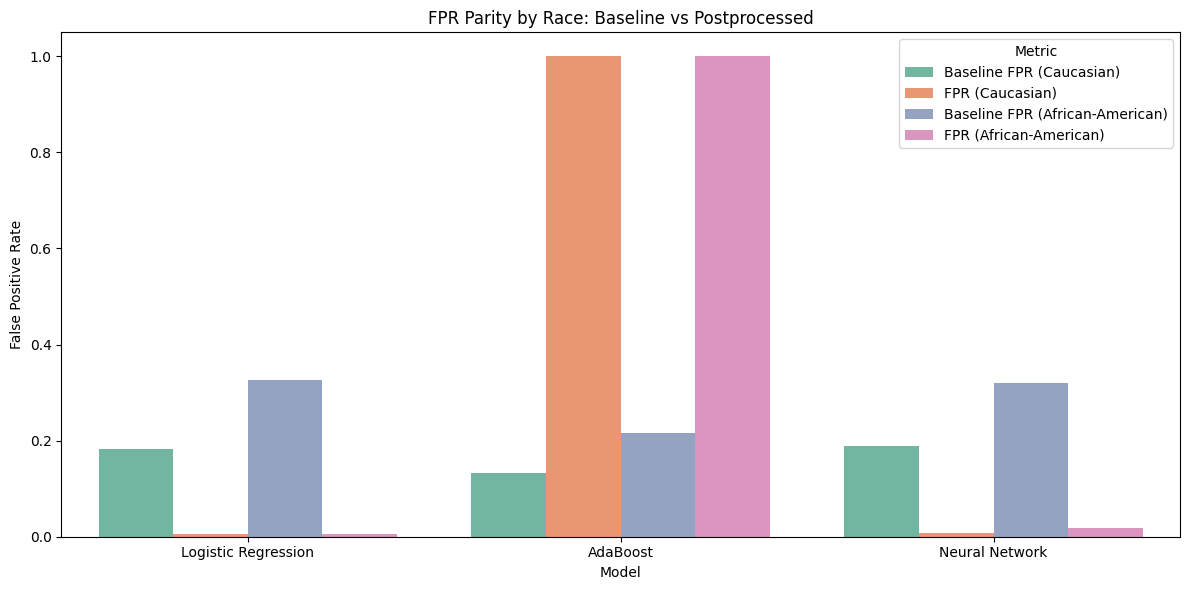

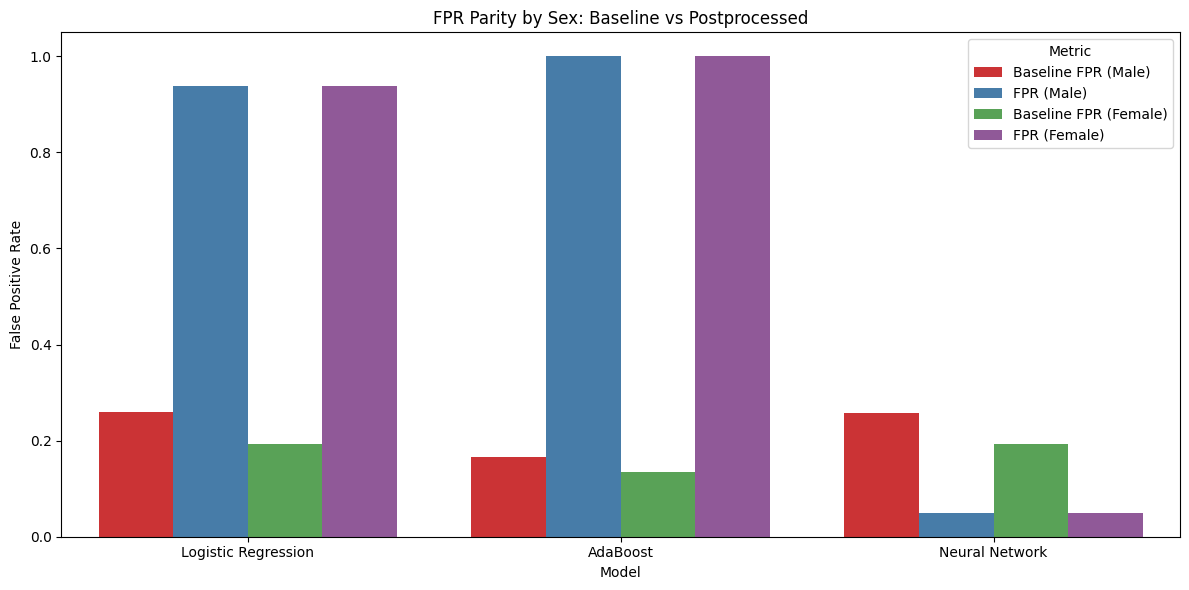

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
race_df = pd.read_csv("../reports/04_fairness/fpr_parity_results_race.csv")
sex_df = pd.read_csv("../reports/04_fairness/fpr_parity_results_sex.csv")

# Prepare Race data for plotting
melted_race = race_df.melt(
    id_vars="Model",
    value_vars=[
        "Baseline FPR (Caucasian)", "FPR (Caucasian)",
        "Baseline FPR (African-American)", "FPR (African-American)"
    ],
    var_name="Metric", value_name="FPR"
)

# Split into Group + Phase
melted_race["Group"] = melted_race["Metric"].apply(lambda x: "Caucasian" if "Caucasian" in x else "African-American")
melted_race["Phase"] = melted_race["Metric"].apply(lambda x: "Baseline" if "Baseline" in x else "Postprocessed")

# Plot Race
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_race, x="Model", y="FPR", hue="Metric", palette="Set2")
plt.title("FPR Parity by Race: Baseline vs Postprocessed")
plt.ylabel("False Positive Rate")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("../reports/04_fairness/fpr_parity_comparison_race.png")
plt.show()

# Prepare Sex data for plotting
melted_sex = sex_df.melt(
    id_vars="Model",
    value_vars=[
        "Baseline FPR (Male)", "FPR (Male)",
        "Baseline FPR (Female)", "FPR (Female)"
    ],
    var_name="Metric", value_name="FPR"
)

# Split into Group + Phase
melted_sex["Group"] = melted_sex["Metric"].apply(lambda x: "Male" if "Male" in x else "Female")
melted_sex["Phase"] = melted_sex["Metric"].apply(lambda x: "Baseline" if "Baseline" in x else "Postprocessed")

# Plot Sex
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_sex, x="Model", y="FPR", hue="Metric", palette="Set1")
plt.title("FPR Parity by Sex: Baseline vs Postprocessed")
plt.ylabel("False Positive Rate")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("../reports/04_fairness/fpr_parity_comparison_sex.png")
plt.show()
